## $\text{price today} = \text{price yesterday} * e^{r} \\ s_{t} = s_{t-1} * e^{r} \\ r = \text{drift + volatility}$

## $\text{drift} = \mu - \frac{1}{2} \sigma^{2} \\ \text{where} \\ \mu = \text{mean} \\ \sigma^{2} = \text{Variance}$

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

<AxesSubplot:xlabel='Date'>

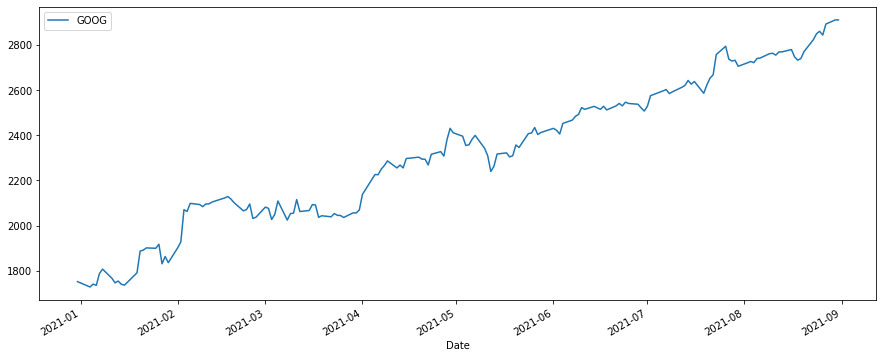

In [2]:
ticker = 'GOOG'
data = pd.DataFrame()
data[ticker] = wb.DataReader(ticker, data_source = 'yahoo', start = '2021-1-1')['Adj Close']
data.plot(figsize=(15,6))

Text(16.192291666666662, 0.5, 'Frequency')

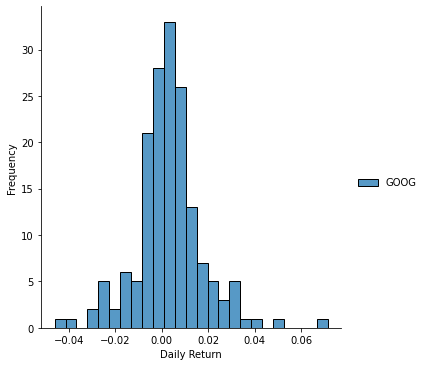

In [3]:
log_return = np.log(1 + data.pct_change())
#Plot
sns.displot(log_return.iloc[1:])
plt.xlabel("Daily Return")
plt.ylabel("Frequency")

In [4]:
u = log_return.mean()
var = log_return.var()
drift = u - (0.5*var)

In [5]:
drift

GOOG    0.002924
dtype: float64

## $\text{Volatility} = \sigma Z \\ \text{where} \\ \sigma = \text{standard deviation} \\ Z \in (0, 1), \ Z = rand(0, 1)$

In [6]:
stdev = log_return.std()
days = 50
trials = 10000
#Returns random variables between 0 and 1
x = np.random.rand(days, trials) #days, trials
#Percent Point Function - the inverse of a CDF
Z = norm.ppf(x) 
vol = stdev.values * Z

## $\text{Daily returns} \\ e^{r} = e^{\text{drift} + \text{volatility}}$

In [7]:
daily_returns = np.exp(drift.values + vol)

## $\text{price today} = \text{price yesterday} * e^{r} \\ s_{t} = s_{t-1} * e^{r}$

In [8]:
# for every trail
price_paths = np.zeros_like(daily_returns)
# Day 0  for every trial in the simulation
price_paths[0] = data.iloc[-1]
for t in range(1, days): #future 50 days results
    price_paths[t] = price_paths[t-1] * daily_returns[t]

In [9]:
# Next 50 days results each with 10000 trails
price_paths

array([[2909.23999023, 2909.23999023, 2909.23999023, ..., 2909.23999023,
        2909.23999023, 2909.23999023],
       [2921.93000315, 2968.00302442, 2967.31615691, ..., 2931.87052753,
        2892.37472822, 2958.75434692],
       [2861.6215953 , 3003.13869364, 2923.03365108, ..., 2915.7643226 ,
        2917.97240022, 3002.7864042 ],
       ...,
       [3877.80198499, 3230.23038387, 3407.92805238, ..., 2993.32290602,
        3385.83569185, 2957.67531501],
       [3908.24345933, 3285.47972093, 3412.07821956, ..., 2960.22964574,
        3399.07964931, 2988.9072878 ],
       [4032.36588663, 3289.17598565, 3501.61435749, ..., 2973.10756156,
        3421.09479279, 2961.34982255]])

## Beta of every stock 
## $\beta_{i} = \frac{\text{Cov(m, i)}}{Var(m)} = \frac{\sigma_{i, m}}{\sigma^{2}_{m}}\\ \text{where,} \\ \text{i, is the returns on our portfolio or stock - DEPENDENT VARIABLE} \\ \text{m, is the market returns or index - INDEPENDENT VARIABLE} \\ \text{Variance is the square of standard deviation.}$

In [10]:
ann_return = np.exp(u * 252).values - 1

In [25]:
covar = log_return.cov() * 252  # Annualized
market_var = var * 252 #Annualized

In [26]:
beta = covar/market_var

In [36]:
stdev_return = pd.DataFrame(stdev * 250 ** 0.5, columns=['STD'])

In [37]:
beta = beta.merge(stdev_return, left_index=True, right_index=True)

## CAPM
## $E(R_{i}) = R_{f} + \beta_{i}(E(R_{m}) - R_{f}) \\ \text{where,} \\ 
E(R_{i})=\text{capital asset expected return} \\
R_{f}=\text{risk-free rate of interest} \\
\beta_i=\text{sensitivity} \\
E(R_{m})=\text{expected return of the market}$

In [46]:
# Let assume risk free be 0.025 or 2.5%
r_f = 0.025
# CAPM
for i, row in beta.iterrows():
    beta.at[i,'CAPM'] = r_f + (row[i] * (ann_return - r_f))

## Sharpe
## $\text{Sharpe} = \frac{E(R_{i}) - R_{f}}{\sigma_{i}} \\ \text{Where,} \\ E = \text{expected return} \\ R_{i} = \text{asset return} \\ R_{f} = \text{risk free return} \\ \sigma_{i} = \text{standard deviation of the asset}$

In [48]:
# Sharpe
for i, row in beta.iterrows():
    beta.at[i,'Sharpe'] = ((row['CAPM'] - r_f)/(row['STD']))

In [50]:
beta.rename(columns={"GOOG":"Beta"}, inplace=True)

In [59]:
predicted = pd.DataFrame(price_paths)
predicted0 = predicted.iloc[0,0]
predicted = predicted.iloc[-1]
predList = list(predicted)
over = list()
less = list()
for i in predList:
    pred_pct = (i*100)/predicted0
    curr_pred = pred_pct - 100
    if curr_pred >= 0.2:
        over.append(pred_pct)
    else:
        less.append(pred_pct)

In [61]:
len(over)/(len(over)+len(less))

0.9149

c:\users\bala.na\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\bala.na\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Days: 252
Expected Value: $3380.36
Return: 13.94%
Probability of Breakeven: 0.9149


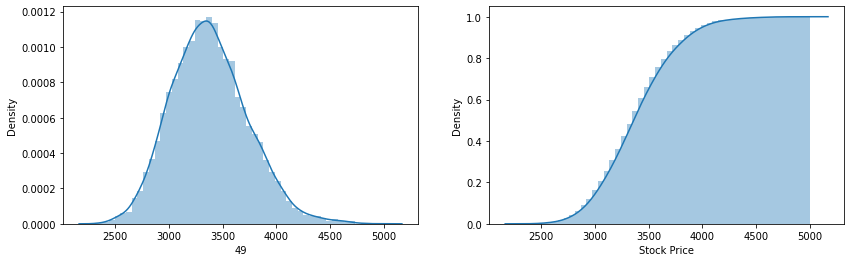

In [66]:
fig, ax = plt.subplots(1,2, figsize=(14,4))
sns.distplot(predicted, ax=ax[0])
sns.distplot(predicted, hist_kws={'cumulative':True},kde_kws={'cumulative':True},ax=ax[1])
plt.xlabel("Stock Price")
days = 252
print(f"Days: {days}")
print(f"Expected Value: ${round(predicted.mean(),2)}")
print(f"Return: {round(100*(predicted.mean() - price_paths[0,1])/predicted.mean(),2)}%")
print(f"Probability of Breakeven: {len(over)/(len(over)+len(less))}")
plt.show()